# Clustering evaluation on high dimensional data

The goal of this notebook is to provide a basic template walkthrough of obtaining and preparing a number of (simple) high dimensional datasets that can reasonably used to clustering evaluation. The datasets chosen have associated class labels that *should* be meaningful in terms of how the data clusters, and thus we can use label based clustering evaluation such as ARI and AMI to determine how well different clustering approaches are performing.

The primary purpose of this notebook is to provide a set of baseline datasets that clustering algorithm developers can try their algorithms out on. Performing reasinably well on these datasets is a necessary but not sufficient condition of a good clustering algorithm.

In [127]:
!git branch

  main
* new-feature


In [110]:
data_folder = '../data'

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn import cluster

import numpy as np
import pandas as pd
import requests
import zipfile
import imageio
import os
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import cdlib.algorithms as cd

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'infomap', 'wurlitzer', 'graph_tool', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# MNIST, USPS and Pendigits are easy

We can use the sklearn API to fetch data for the Pendigits, MNIST and USPS datasets.

Of these datasets pendigits is the smallest, with only 1797 samples, and is only 64 dimensional. This makes a good first dataset to test things out on -- the dataset is small enough that practically anything should be able to run on this efficiently.

USPS provides a slightly more challenging dataset, with almost 10,000 samples and 256 dimensions, but is still samall enough to be tractable for even naive clustering implementations.

MNIST provides a good basic scaling test with 70,000 samples in 784 dimensions. In practice this is not a very large dataset compared to many that people want to cluster, although the dimensionality may provide some challenges.

In [4]:
digits = load_digits()
mnist = fetch_openml("MNIST_784")
usps = fetch_openml("USPS")

# Buildings and COIL are harder

The buildings and COIL-20 datasets provide some slightly more challenging image based problems, with more complex images to be dealt with. Both are still small in number of samples, so should be easily tractable. COIL *should* be relatively easy to cluster since the different classes should provide fairly tight and distinct clusters (being 72 images of the same object from different angles for each class). The buildings dataset, which has colour images from many angles and different lighting conditions, should be a much more challenging problem to cluster if using simple euclidean distance on the flattened vectors.

In [112]:
if not os.path.isdir(data_folder):
    bashCommand = f"mkdir {data_folder}"
    os.system(bashCommand)

### COIL-20

In [113]:
%%time
if not os.path.isfile(f'{data_folder}/coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open(f'{data_folder}/coil20.zip', "wb") as code:
        code.write(results.content)

CPU times: user 35.4 ms, sys: 20 ms, total: 55.5 ms
Wall time: 757 ms


In [114]:
import re
images_zip = zipfile.ZipFile(f'{data_folder}/coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))
images_zip.extractall(data_folder + '/.')

In [122]:
%%time
coil_feature_vectors = []
for filename in filelist:
    im = imageio.imread(data_folder + '/' + filename)
    coil_feature_vectors.append(im.flatten())
coil_20_data = np.asarray(coil_feature_vectors)
coil_20_target = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False).values.astype(np.int32)

CPU times: user 396 ms, sys: 28.2 ms, total: 424 ms
Wall time: 423 ms


## Buildings

In [123]:
if not os.path.isfile(f'{data_folder}/buildings.rar'):
    results = requests.get('http://eprints.lincoln.ac.uk/id/eprint/16079/1/dataset.rar')
    with open(f'{data_folder}/buildings.rar', "wb") as code:
        code.write(results.content)

In [125]:
if not os.path.isfile(f'{data_folder}/sheffield_buildings/Dataset/Dataset/1/S1-01.jpeg'):
    bashCommand1 = f"unrar x {data_folder}/buildings.rar -idq -o+"
    bashCommand2 = f"mv Dataset {data_folder}/sheffield_buildings"
    os.system(bashCommand1)
    os.system(bashCommand2)

In [126]:
buildings_data = []
buildings_target = []
for i in range(1, 41):
    directory = f"{data_folder}/sheffield_buildings/Dataset/{i}"
    images = np.vstack([np.asarray(Image.open(filename).resize((96, 96))).flatten() for filename in glob(f"{directory}/*")])
    labels = np.full(len(glob(f"{directory}/*")), i, dtype=np.int32)
    buildings_data.append(images)
    buildings_target.append(labels)
buildings_data = np.vstack(buildings_data)
buildings_target = np.hstack(buildings_target)

# Clustering metric eval

To make things easier later we will write some short functions to evaluate clusterings (with some special handling of singleton clusters or noise points for clusterign algorithms that support such things), and to plot the results for easy comparison.

In [88]:
def eval_clusters(cluster_labels, true_labels, raw_data, cluster_method="None", min_cluster_size=5):
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes == 1): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes <= min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if np.any(cluster_labels < 0): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [89]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75):
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe["Dim Reduction"].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe["Dim Reduction"] == dim_red)
            ]
            axs[i].bar(
                x=x_positions,
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions += bar_width
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

# Pendigits clustering scores

In [90]:
raw_pendigits = digits.data.astype(np.float32)

In [91]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_pendigits)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_pendigits)
sl_labels = cluster.AgglomerativeClustering(n_clusters=160, linkage="single").fit_predict(raw_pendigits)
db_labels = cluster.DBSCAN(eps=20.0).fit_predict(raw_pendigits)
hd_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(raw_pendigits)

CPU times: user 13.9 s, sys: 350 ms, total: 14.2 s
Wall time: 798 ms


In [92]:
pendigits_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_raw_results_long = pendigits_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_raw_results_long["Dim Reduction"] = "None"

ARI: 0.6692
AMI: 0.7439
Silhouette: 0.1826
ARI: 0.4287
AMI: 0.6092
Silhouette: 0.1193
ARI: 0.5700
AMI: 0.8105
Silhouette: 0.0833
Pct clustered: 90.37%
ARI: 0.8633
AMI: 0.8990
Silhouette: 0.1927
Pct clustered: 74.18%
ARI: 0.3165
AMI: 0.7092
Silhouette: 0.1121
Pct clustered: 80.69%


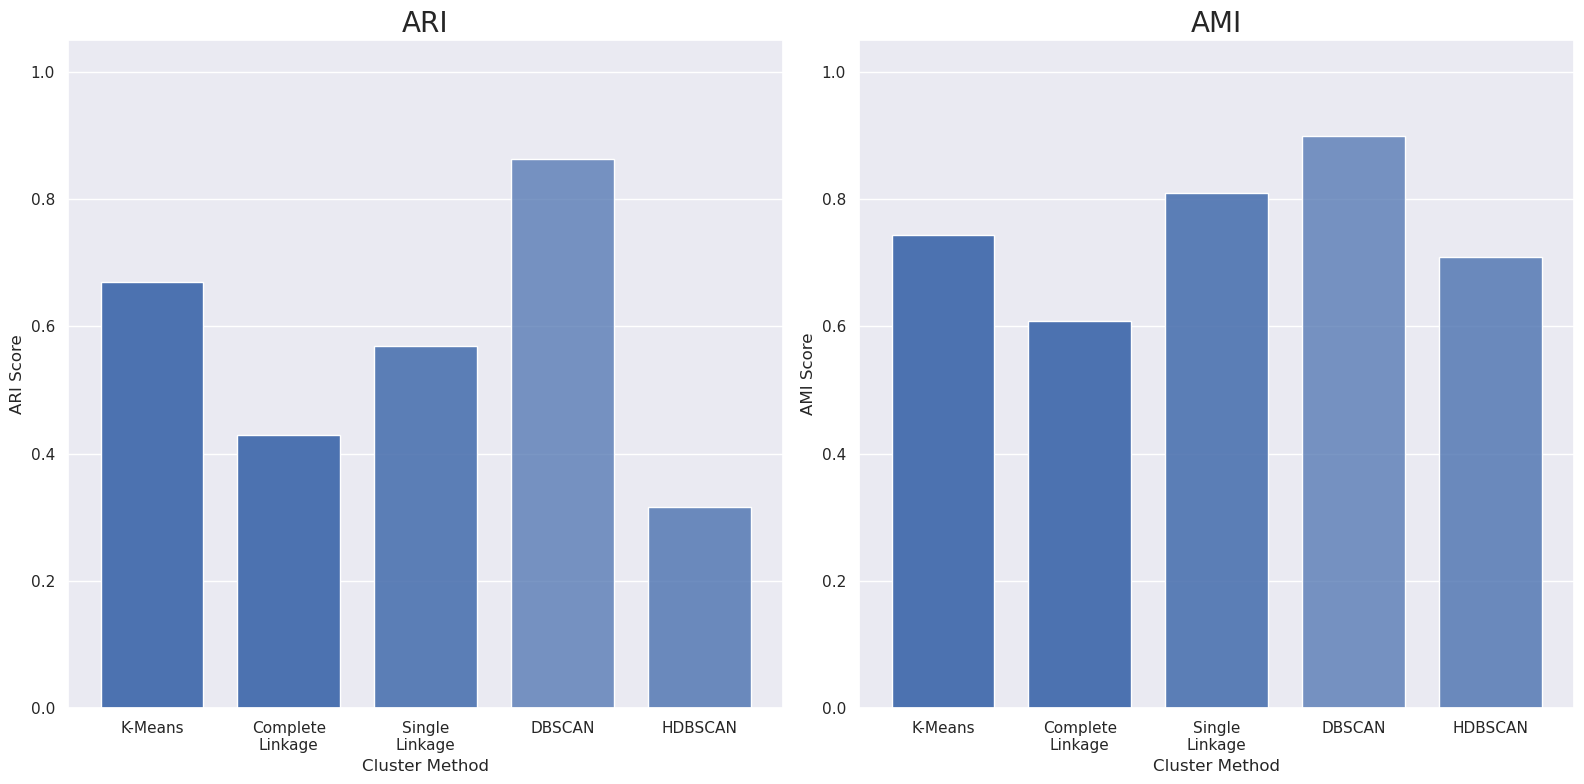

In [93]:
plot_scores(pendigits_raw_results_long)

In [94]:
pca_pendigits = PCA(n_components=16).fit_transform(raw_pendigits)

In [95]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_pendigits)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_pendigits)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=160, linkage="single").fit_predict(pca_pendigits)
db_pca_labels = cluster.DBSCAN(eps=15.0).fit_predict(pca_pendigits)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(pca_pendigits)

CPU times: user 11 s, sys: 274 ms, total: 11.2 s
Wall time: 407 ms


In [96]:
pendigits_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_pca_results_long = pendigits_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.6601
AMI: 0.7312
Silhouette: 0.1818
ARI: 0.4629
AMI: 0.6200
Silhouette: 0.1140
ARI: 0.5225
AMI: 0.8037
Silhouette: 0.0717
Pct clustered: 89.65%
ARI: 0.8283
AMI: 0.8930
Silhouette: 0.1229
Pct clustered: 78.13%
ARI: 0.8841
AMI: 0.9394
Silhouette: 0.2065
Pct clustered: 73.96%


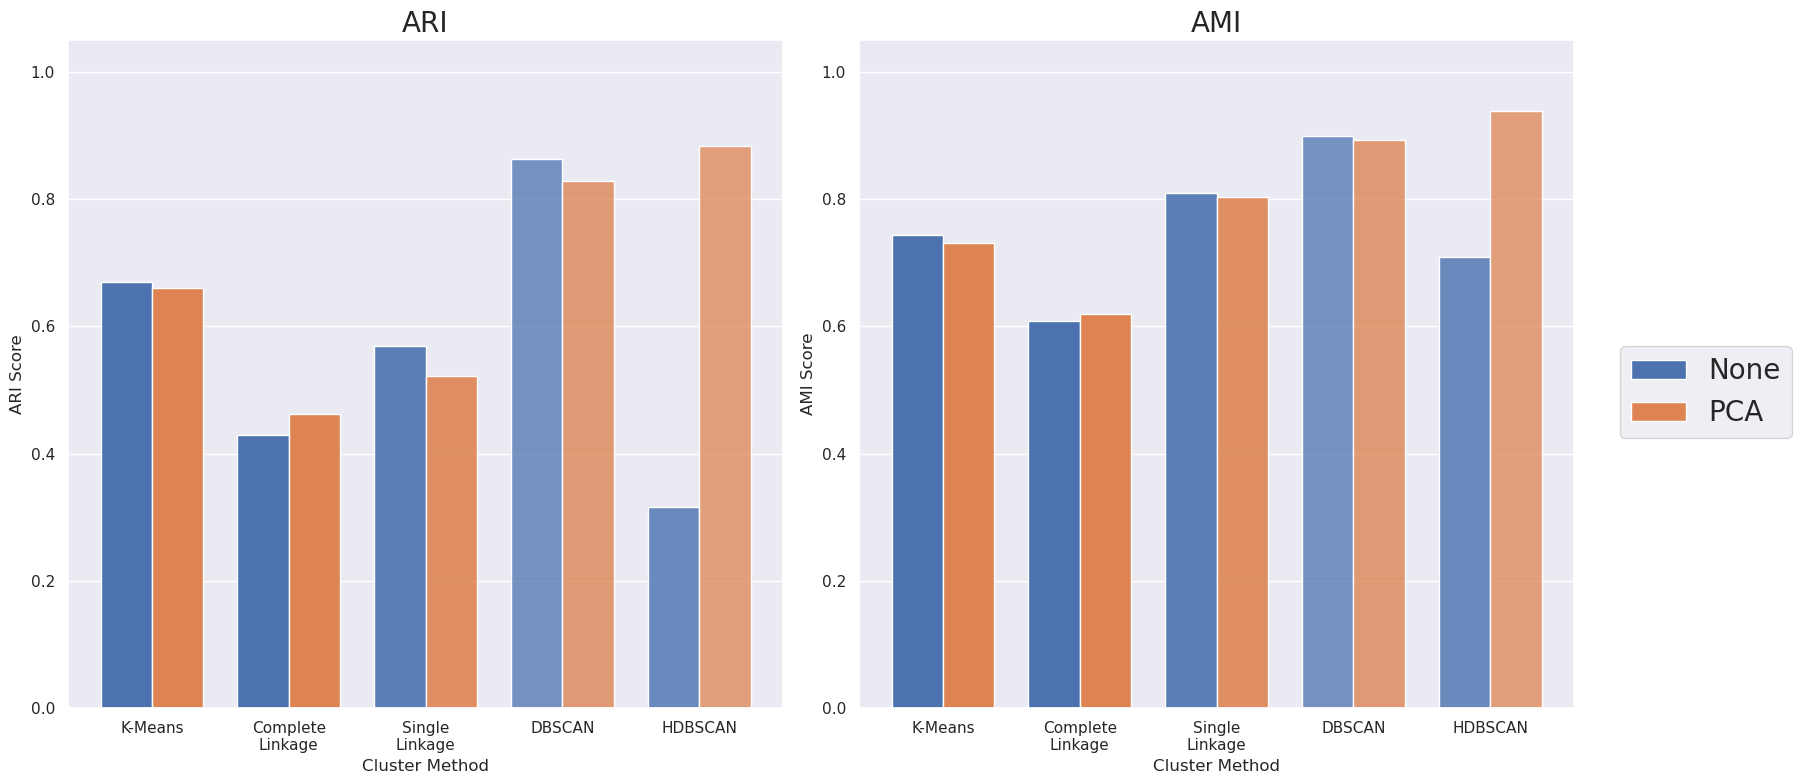

In [97]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long]))

In [98]:
umap_pendigits = umap.UMAP(n_components=4, min_dist=1e-8, random_state=0).fit_transform(raw_pendigits)

In [99]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_pendigits)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_pendigits)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="single").fit_predict(umap_pendigits)
db_umap_labels = cluster.DBSCAN(eps=0.5).fit_predict(umap_pendigits)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=100).fit_predict(umap_pendigits)

CPU times: user 5.46 s, sys: 131 ms, total: 5.59 s
Wall time: 186 ms


In [100]:
pendigits_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, digits.target, raw_pendigits, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, digits.target, raw_pendigits, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, digits.target, raw_pendigits, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, digits.target, raw_pendigits, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, digits.target, raw_pendigits, cluster_method="HDBSCAN"),
    ]
)
pendigits_umap_results_long = pendigits_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
pendigits_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.8213
AMI: 0.9030
Silhouette: 0.1602
ARI: 0.8213
AMI: 0.9030
Silhouette: 0.1602
ARI: 0.8934
AMI: 0.9195
Silhouette: 0.1544
Pct clustered: 99.89%
ARI: 0.9005
AMI: 0.9233
Silhouette: 0.1640
Pct clustered: 99.94%
ARI: 0.9385
AMI: 0.9469
Silhouette: 0.1691
Pct clustered: 97.94%


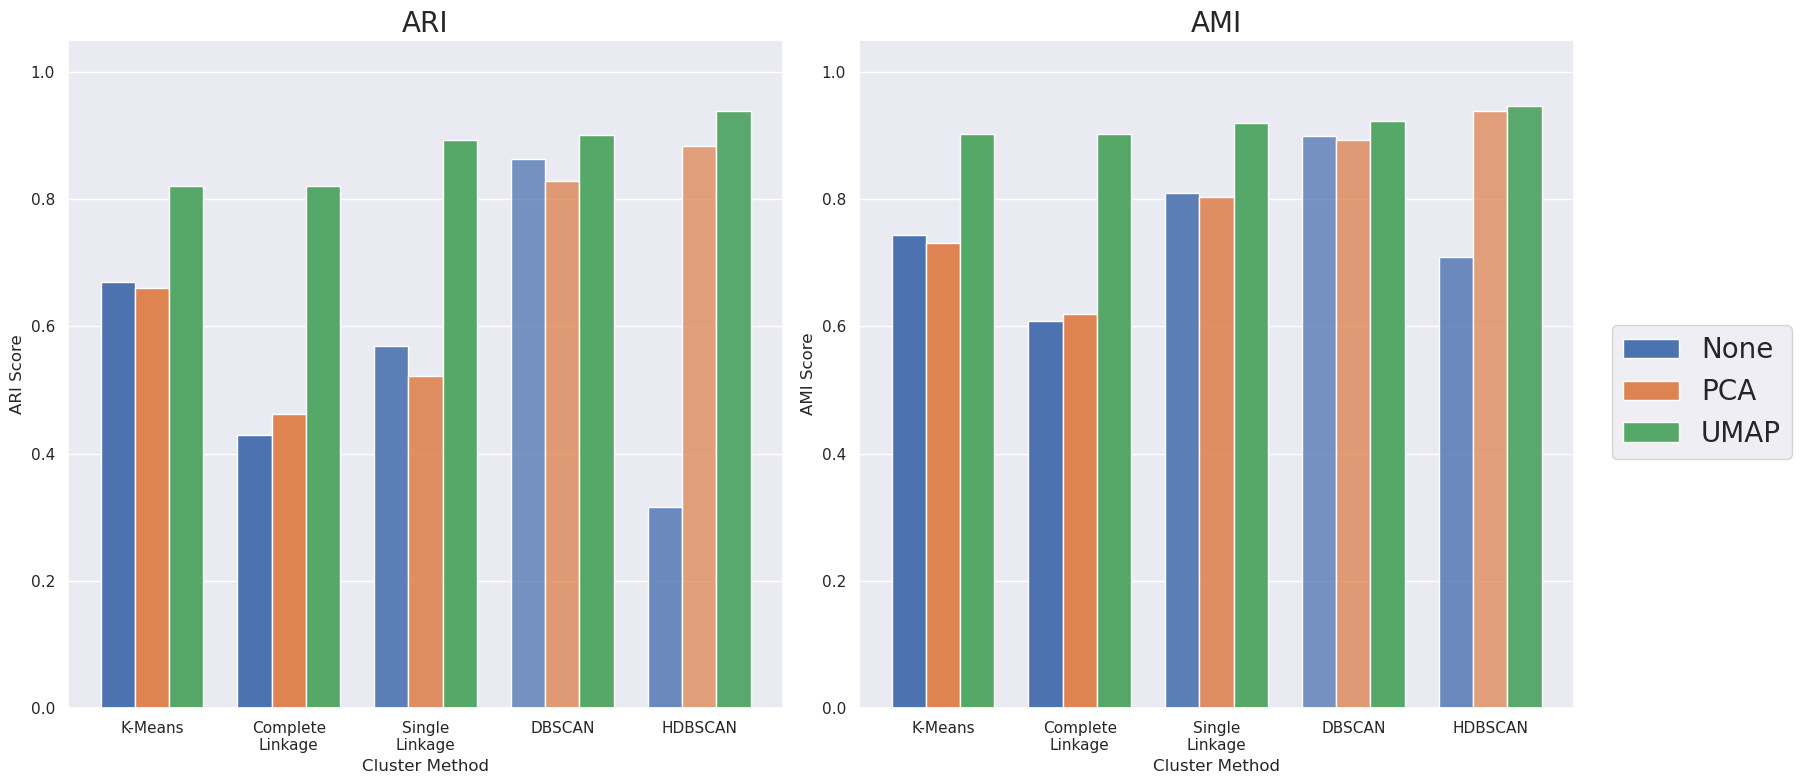

In [101]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long, pendigits_umap_results_long]))

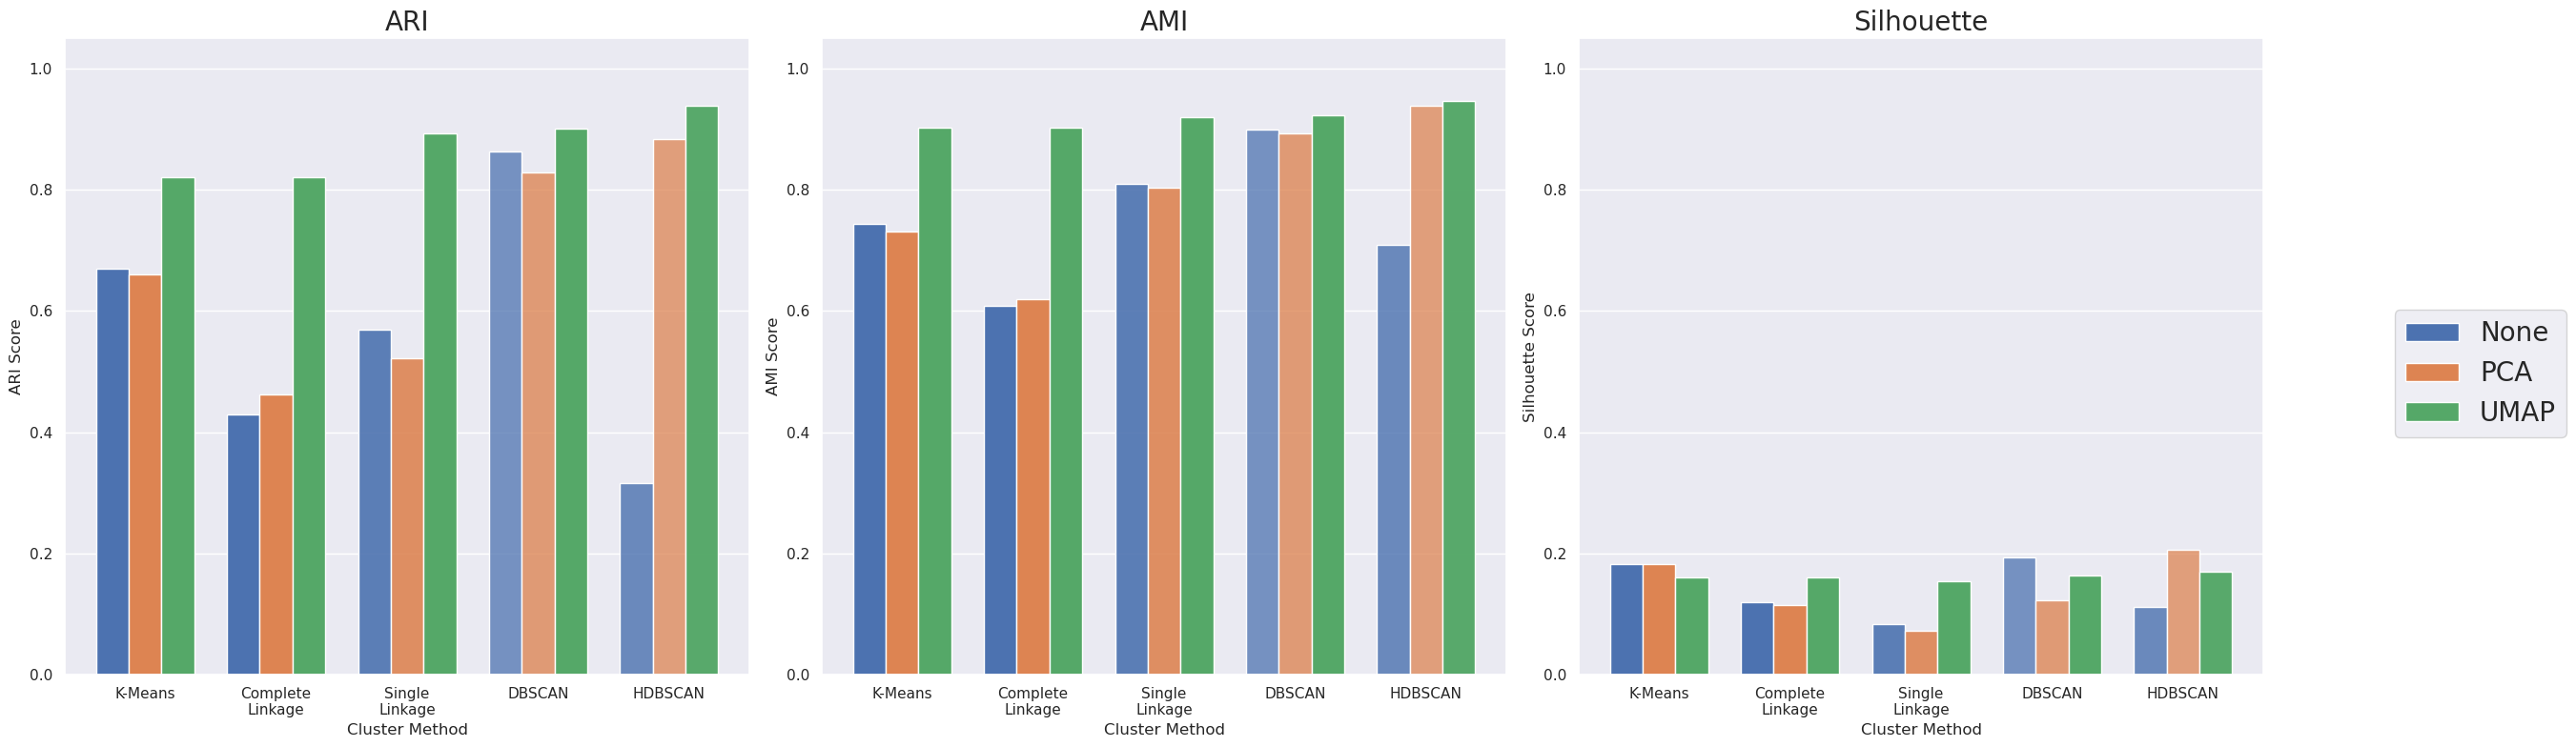

In [102]:
plot_scores(pd.concat([pendigits_raw_results_long, pendigits_pca_results_long, pendigits_umap_results_long]), 
            score_types=("ARI", "AMI", "Silhouette"))

# COIL-20 Clustering

In [25]:
raw_coil = coil_20_data.astype(np.float32)

In [26]:
%%time
km_labels = cluster.KMeans(n_clusters=20).fit_predict(raw_coil)

CPU times: user 1min 34s, sys: 1.49 s, total: 1min 36s
Wall time: 22.1 s


In [27]:
%%time
cl_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(raw_coil)

CPU times: user 17.7 s, sys: 97 ms, total: 17.8 s
Wall time: 16.9 s


In [28]:
%%time
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_coil)

CPU times: user 28.3 s, sys: 104 ms, total: 28.4 s
Wall time: 28.2 s


In [29]:
%%time
db_labels = cluster.DBSCAN(eps=5000.0).fit_predict(raw_coil)

CPU times: user 3.07 s, sys: 259 ms, total: 3.33 s
Wall time: 902 ms


In [30]:
np.unique(db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21])

In [31]:
%%time
hd_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(raw_coil)

CPU times: user 1min 24s, sys: 155 ms, total: 1min 24s
Wall time: 1min 24s


In [32]:
coil_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_raw_results_long = coil_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_raw_results_long["Dim Reduction"] = "None"

ARI: 0.5851
AMI: 0.7666
Silhouette: 0.2146
ARI: 0.3198
AMI: 0.6212
Silhouette: 0.1567
ARI: 0.5900
AMI: 0.8890
Silhouette: 0.0987
Pct clustered: 94.93%
ARI: 0.8971
AMI: 0.9545
Silhouette: 0.2508
Pct clustered: 78.68%
ARI: 0.8699
AMI: 0.9606
Silhouette: 0.1995
Pct clustered: 93.47%


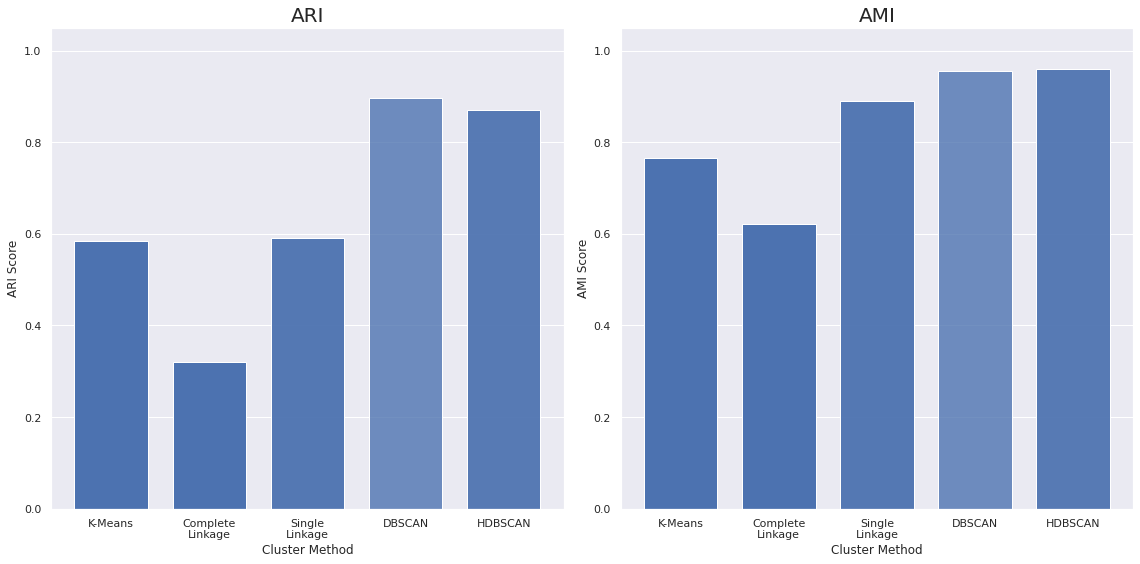

In [33]:
plot_scores(coil_raw_results_long)

In [34]:
pca_coil = PCA(n_components=64).fit_transform(raw_coil)

In [35]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=20).fit_predict(pca_coil)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(pca_coil)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_coil)
db_pca_labels = cluster.DBSCAN(eps=4000.0).fit_predict(pca_coil)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(pca_coil)

CPU times: user 3.83 s, sys: 79.2 ms, total: 3.91 s
Wall time: 792 ms


In [36]:
coil_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_pca_results_long = coil_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.6016
AMI: 0.7667
Silhouette: 0.2112
ARI: 0.3591
AMI: 0.6499
Silhouette: 0.1805
ARI: 0.8499
AMI: 0.9609
Silhouette: 0.1729
Pct clustered: 94.72%
ARI: 0.8822
AMI: 0.9640
Silhouette: 0.2119
Pct clustered: 92.64%
ARI: 0.9657
AMI: 0.9808
Silhouette: 0.2028
Pct clustered: 93.68%


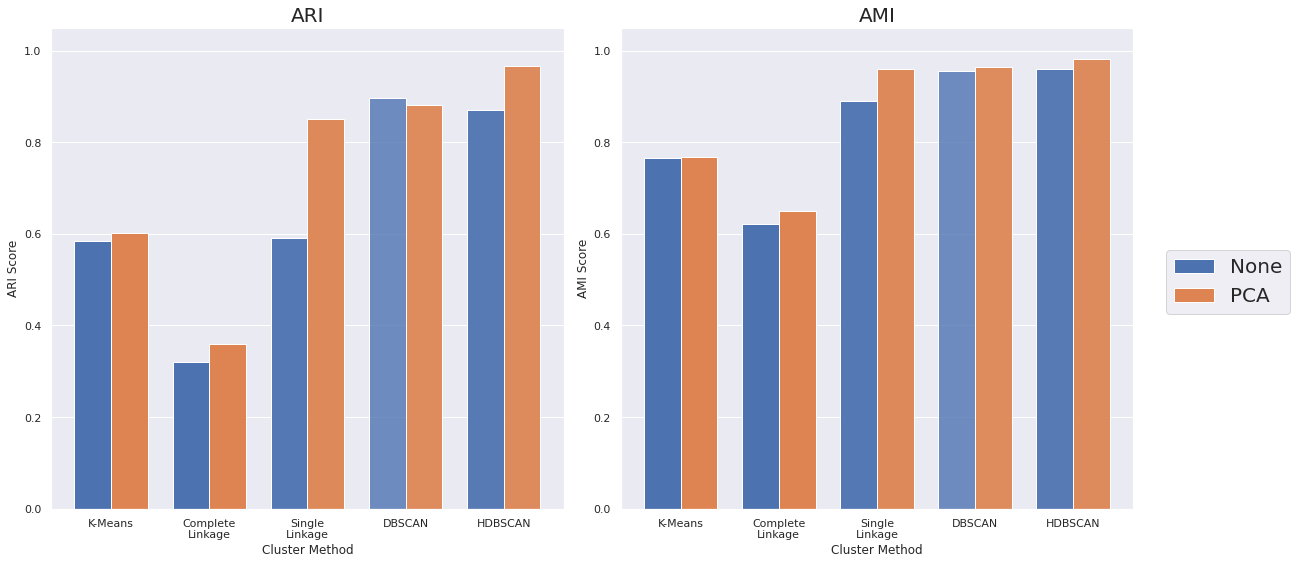

In [37]:
plot_scores(pd.concat([coil_raw_results_long, coil_pca_results_long]))

In [38]:
umap_coil = umap.UMAP(n_neighbors=5, n_components=4, min_dist=1e-8, random_state=0, n_epochs=1000).fit_transform(raw_coil)

In [39]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=20).fit_predict(umap_coil)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=20, linkage="complete").fit_predict(umap_coil)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_coil)
db_umap_labels = cluster.DBSCAN(eps=0.3).fit_predict(umap_coil)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_coil)

CPU times: user 1.63 s, sys: 33.2 ms, total: 1.66 s
Wall time: 289 ms


In [40]:
coil_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, coil_20_target, raw_coil, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, coil_20_target, raw_coil, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, coil_20_target, raw_coil, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, coil_20_target, raw_coil, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, coil_20_target, raw_coil, cluster_method="HDBSCAN"),
    ]
)
coil_umap_results_long = coil_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
coil_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.8525
AMI: 0.9277
Silhouette: 0.1542
ARI: 0.8457
AMI: 0.9323
Silhouette: 0.1610
ARI: 0.6828
AMI: 0.8499
Silhouette: 0.0755
Pct clustered: 95.90%
ARI: 0.7788
AMI: 0.9059
Silhouette: 0.0539
Pct clustered: 98.82%
ARI: 0.8058
AMI: 0.9403
Silhouette: 0.0865
Pct clustered: 99.24%


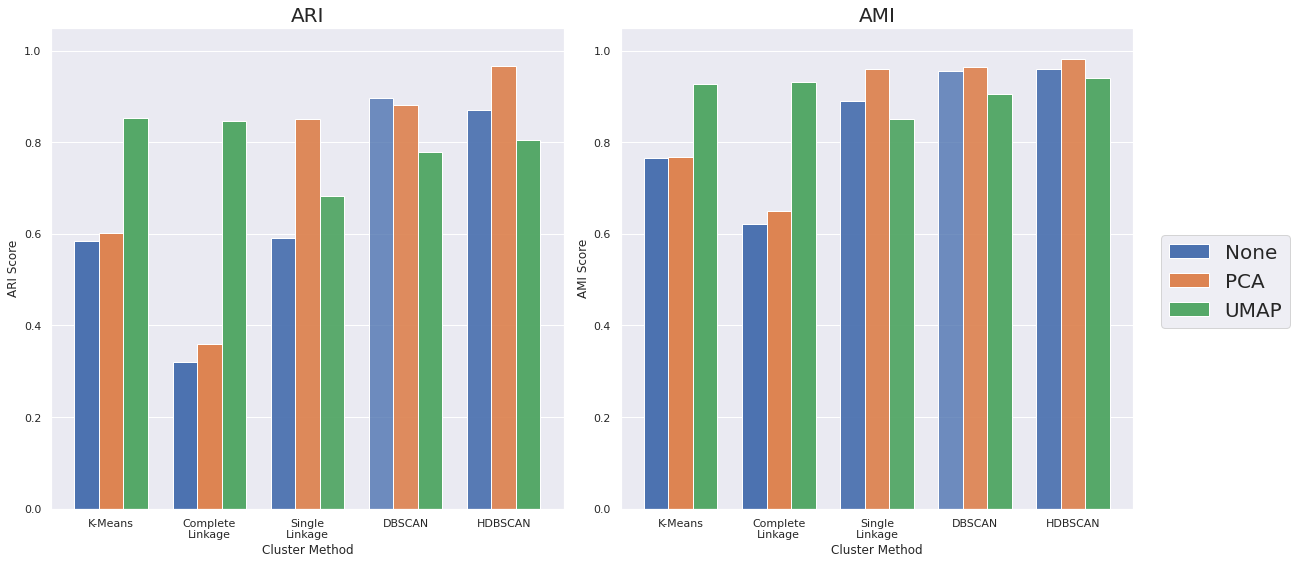

In [41]:
plot_scores(pd.concat([coil_raw_results_long, coil_pca_results_long, coil_umap_results_long]))

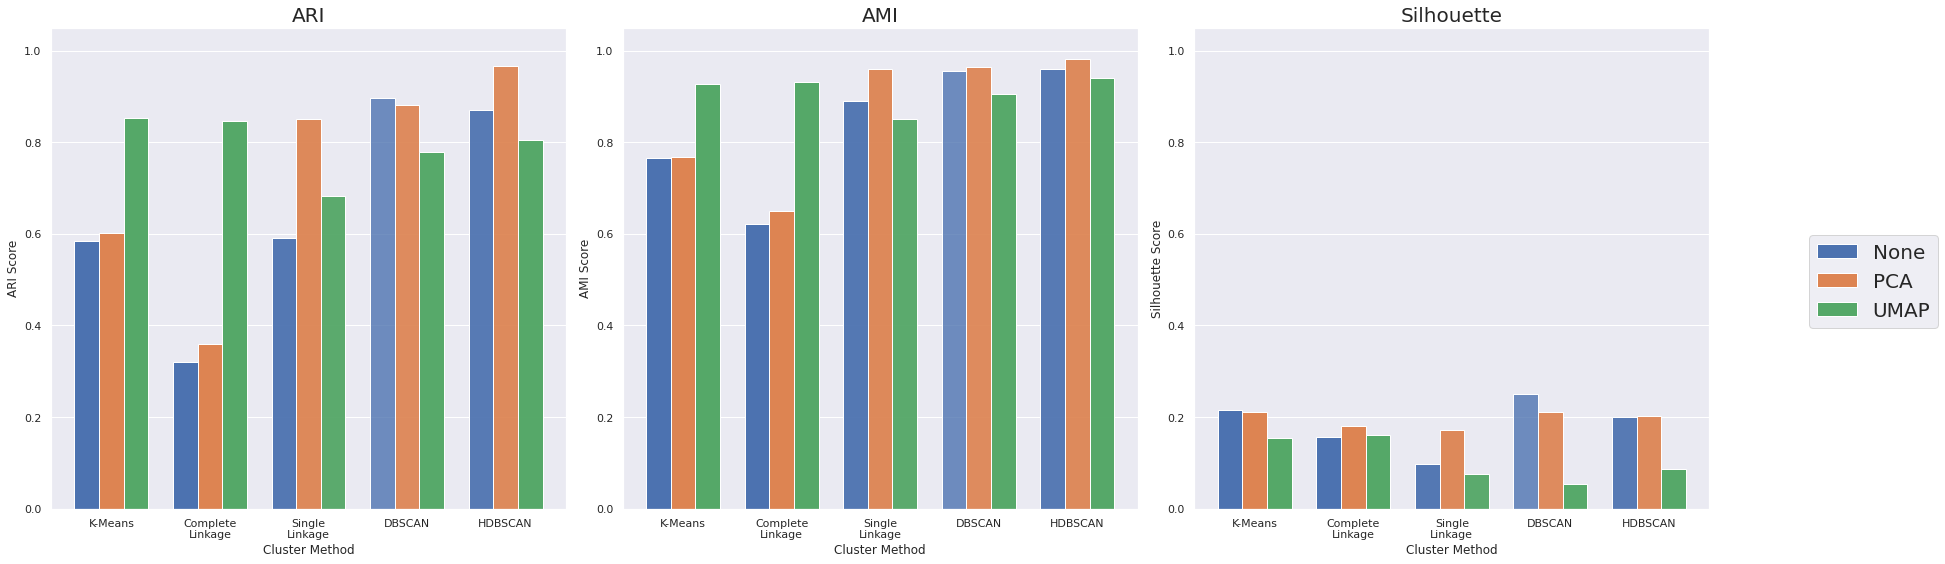

In [42]:
plot_scores(
    pd.concat([coil_raw_results_long, coil_pca_results_long, coil_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# MNIST Clustering

In [43]:
raw_mnist = mnist.data.astype(np.float32)[:35000]

In [44]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_mnist)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_mnist)
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_mnist)
db_labels = cluster.DBSCAN(eps=1000.0).fit_predict(raw_mnist)
hd_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(raw_mnist)

CPU times: user 1h 4min 28s, sys: 23.3 s, total: 1h 4min 52s
Wall time: 1h 52s


In [45]:
mnist_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_raw_results_long = mnist_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_raw_results_long["Dim Reduction"] = "None"

ARI: 0.3559
AMI: 0.4773
Silhouette: 0.0558
ARI: 0.1013
AMI: 0.2630
Silhouette: 0.0151
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1518
Pct clustered: 99.77%
ARI: 0.1101
AMI: 0.2756
Silhouette: -0.1342
Pct clustered: 24.01%
ARI: 0.9989
AMI: 0.9974
Silhouette: 0.2102
Pct clustered: 15.03%


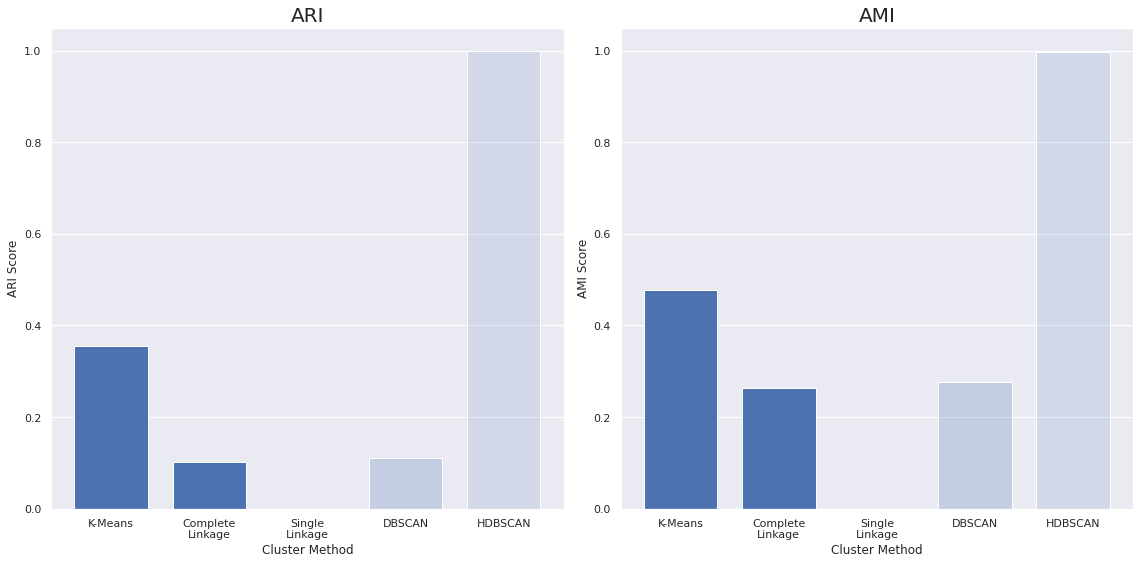

In [46]:
plot_scores(mnist_raw_results_long)

In [47]:
pca_mnist = PCA(n_components=32).fit_transform(raw_mnist)

In [48]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_mnist)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_mnist)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_mnist)
db_pca_labels = cluster.DBSCAN(eps=600.0).fit_predict(pca_mnist)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(pca_mnist)

CPU times: user 2min 32s, sys: 9.29 s, total: 2min 41s
Wall time: 2min 5s


In [49]:
mnist_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_pca_results_long = mnist_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.3540
AMI: 0.4748
Silhouette: 0.0560
ARI: 0.1154
AMI: 0.3349
Silhouette: 0.0342
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1333
Pct clustered: 99.78%
ARI: 0.1220
AMI: 0.3098
Silhouette: -0.1781
Pct clustered: 26.87%
ARI: 0.9938
AMI: 0.9881
Silhouette: 0.2167
Pct clustered: 14.54%


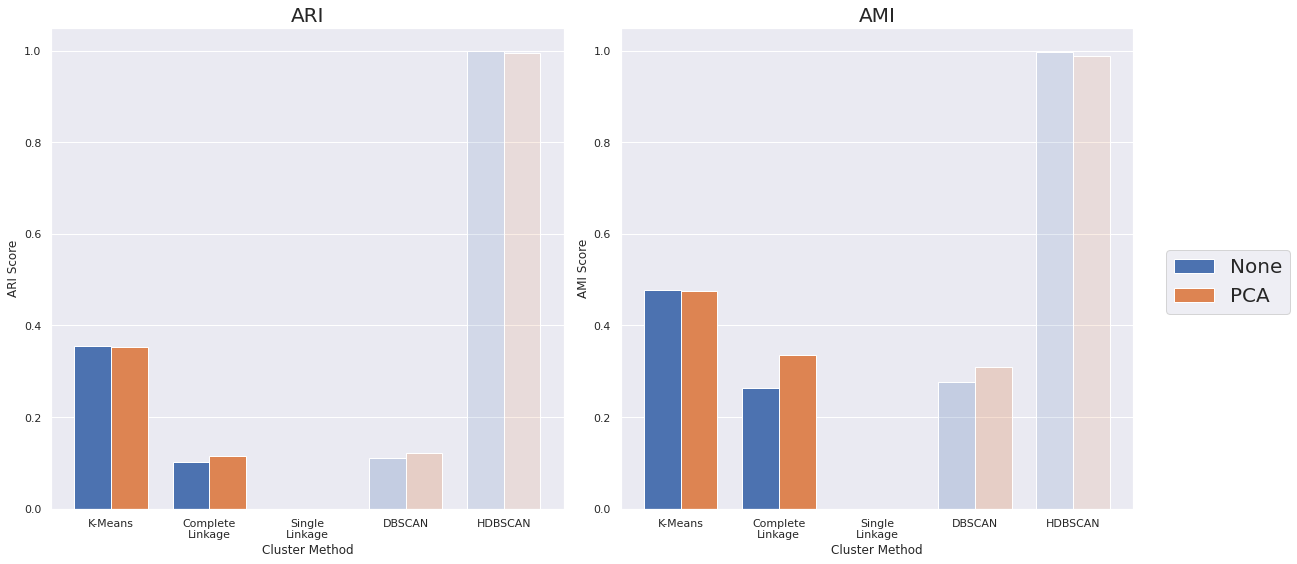

In [50]:
plot_scores(pd.concat([mnist_raw_results_long, mnist_pca_results_long]))

In [51]:
umap_mnist = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_mnist)

In [52]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_mnist)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_mnist)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_mnist)
db_umap_labels = cluster.DBSCAN(eps=0.1).fit_predict(umap_mnist)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_mnist)

CPU times: user 53.9 s, sys: 2.86 s, total: 56.8 s
Wall time: 52.1 s


In [53]:
mnist_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, mnist.target[:35000], raw_mnist, cluster_method="HDBSCAN"),
    ]
)
mnist_umap_results_long = mnist_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
mnist_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.7662
AMI: 0.8372
Silhouette: 0.0333
ARI: 0.7760
AMI: 0.8448
Silhouette: 0.0298
ARI: 0.7067
AMI: 0.8428
Silhouette: -0.0535
Pct clustered: 99.73%
ARI: 0.7940
AMI: 0.8110
Silhouette: -0.1874
Pct clustered: 92.53%
ARI: 0.9180
AMI: 0.9059
Silhouette: 0.0451
Pct clustered: 99.25%


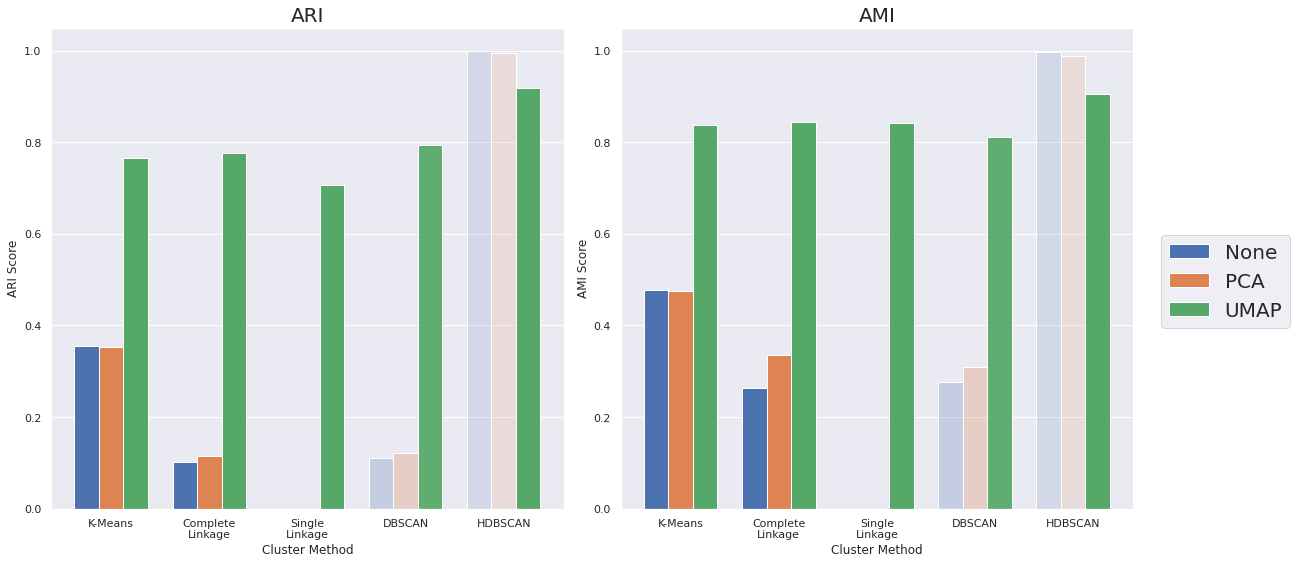

In [54]:
plot_scores(pd.concat([mnist_raw_results_long, mnist_pca_results_long, mnist_umap_results_long]))

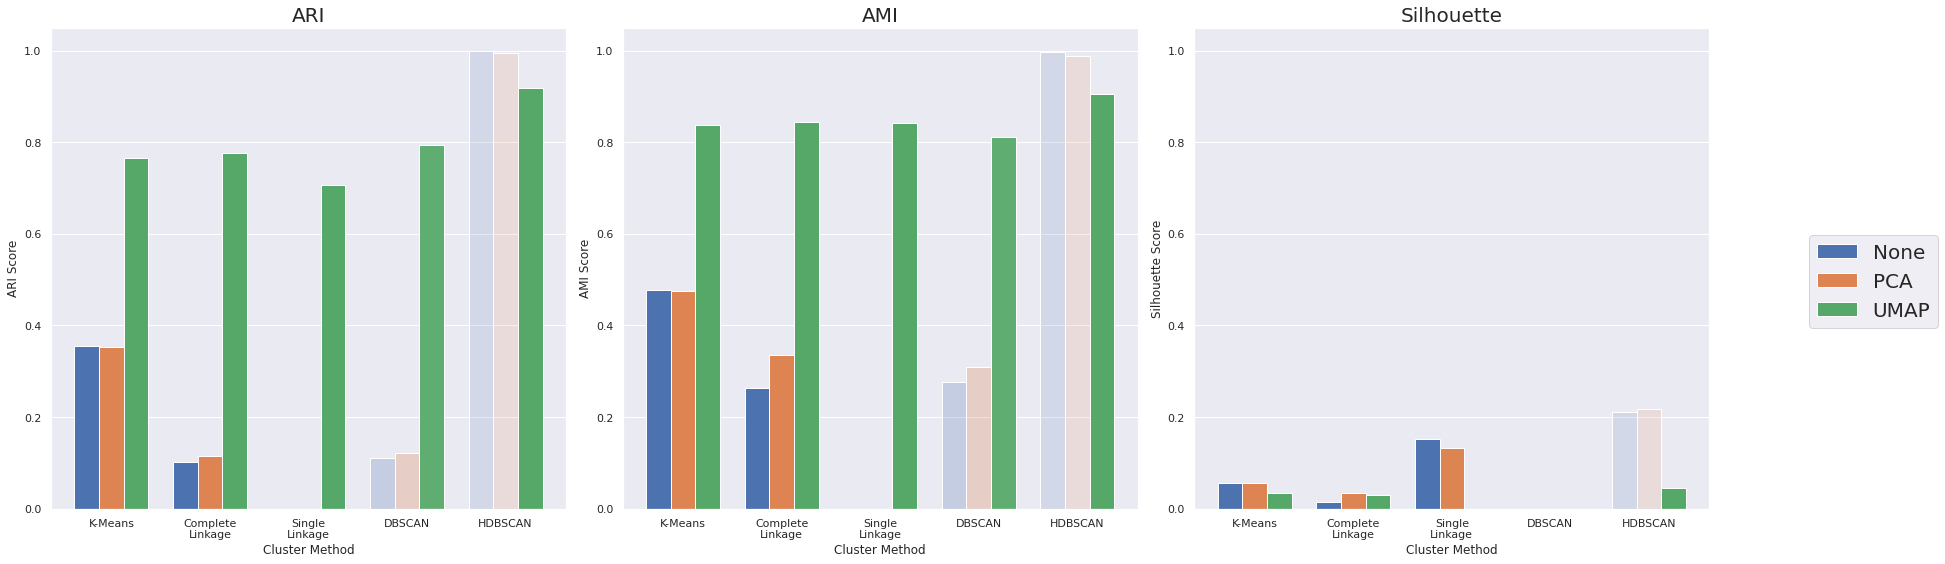

In [55]:
plot_scores(
    pd.concat([mnist_raw_results_long, mnist_pca_results_long, mnist_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# USPS Clustering

In [56]:
raw_usps = usps.data.astype(np.float32)

In [57]:
%%time
km_labels = cluster.KMeans(n_clusters=10).fit_predict(raw_usps)
cl_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(raw_usps)
sl_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(raw_usps)
db_labels = cluster.DBSCAN(eps=3.5).fit_predict(raw_usps)
hd_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(raw_usps)

CPU times: user 1min 33s, sys: 930 ms, total: 1min 34s
Wall time: 1min 17s


In [58]:
usps_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_raw_results_long = usps_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_raw_results_long["Dim Reduction"] = "None"

ARI: 0.5361
AMI: 0.6128
Silhouette: 0.1582
ARI: 0.1881
AMI: 0.3712
Silhouette: 0.0414
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1075
Pct clustered: 99.13%
ARI: 0.1936
AMI: 0.4639
Silhouette: -0.1174
Pct clustered: 47.35%
ARI: 0.9369
AMI: 0.9251
Silhouette: 0.4302
Pct clustered: 27.37%


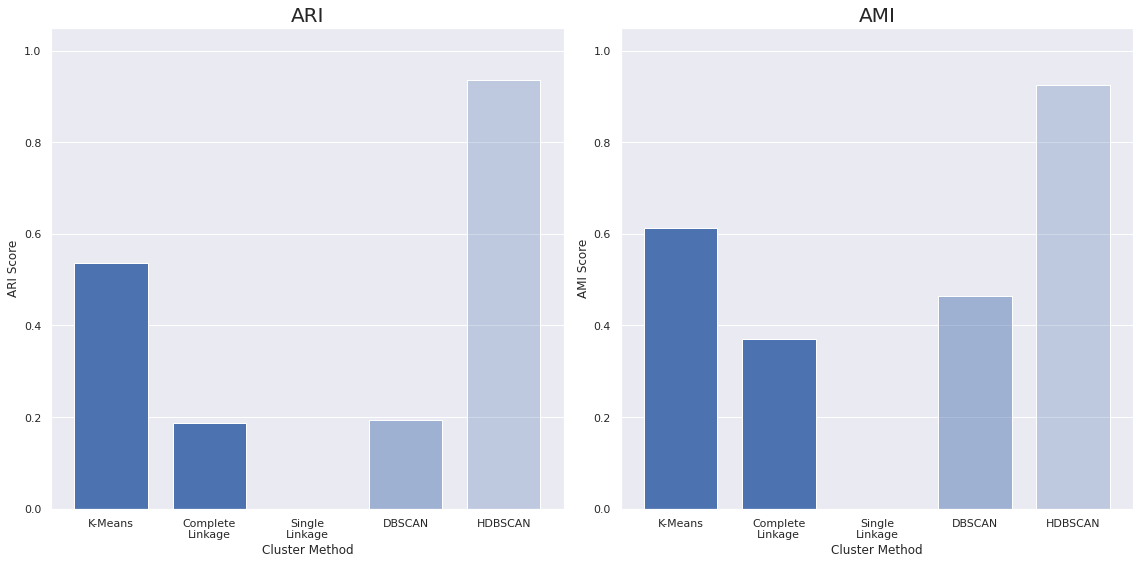

In [59]:
plot_scores(usps_raw_results_long)

In [60]:
pca_usps = PCA(n_components=32).fit_transform(raw_usps)

In [61]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=10).fit_predict(pca_usps)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(pca_usps)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(pca_usps)
db_pca_labels = cluster.DBSCAN(eps=2.0).fit_predict(pca_usps)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(pca_usps)

CPU times: user 19.2 s, sys: 655 ms, total: 19.8 s
Wall time: 11.1 s


In [62]:
usps_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_pca_results_long = usps_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.5394
AMI: 0.6148
Silhouette: 0.1585
ARI: 0.3321
AMI: 0.4730
Silhouette: 0.1053
ARI: 0.0000
AMI: 0.0000
Silhouette: 0.1896
Pct clustered: 99.12%
ARI: 0.9765
AMI: 0.8709
Silhouette: 0.3859
Pct clustered: 18.18%
ARI: 0.9606
AMI: 0.9390
Silhouette: 0.3968
Pct clustered: 29.19%


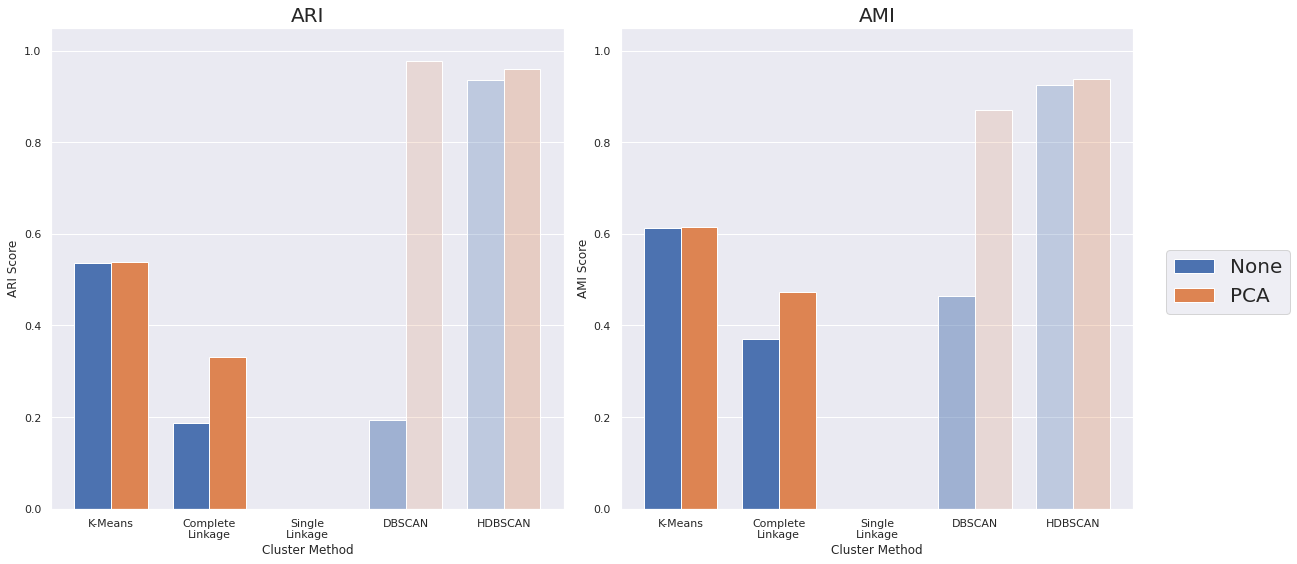

In [63]:
plot_scores(pd.concat([usps_raw_results_long, usps_pca_results_long]))

In [64]:
umap_usps = umap.UMAP(n_neighbors=10, n_components=4, min_dist=1e-8, random_state=42, n_epochs=500).fit_transform(raw_usps)

In [65]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=10).fit_predict(umap_usps)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=10, linkage="complete").fit_predict(umap_usps)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=80, linkage="single").fit_predict(umap_usps)
db_umap_labels = cluster.DBSCAN(eps=0.15).fit_predict(umap_usps)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_usps)

CPU times: user 6.03 s, sys: 224 ms, total: 6.25 s
Wall time: 3.68 s


In [66]:
usps_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, usps.target, raw_usps, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, usps.target, raw_usps, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, usps.target, raw_usps, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, usps.target, raw_usps, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, usps.target, raw_usps, cluster_method="HDBSCAN"),
    ]
)
usps_umap_results_long = usps_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
usps_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.9386
AMI: 0.9206
Silhouette: 0.1424
ARI: 0.7325
AMI: 0.8476
Silhouette: 0.0832
ARI: 0.9402
AMI: 0.9217
Silhouette: 0.0710
Pct clustered: 98.95%
ARI: 0.8943
AMI: 0.8772
Silhouette: -0.1237
Pct clustered: 97.26%
ARI: 0.9383
AMI: 0.9206
Silhouette: 0.1428
Pct clustered: 99.81%


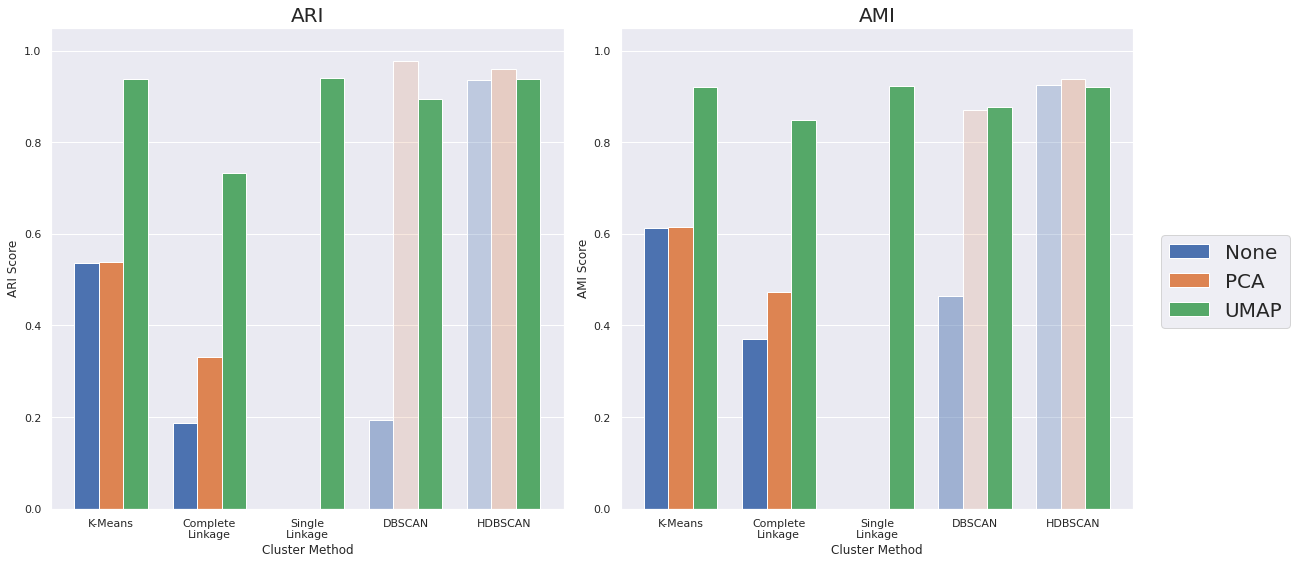

In [67]:
plot_scores(pd.concat([usps_raw_results_long, usps_pca_results_long, usps_umap_results_long]))

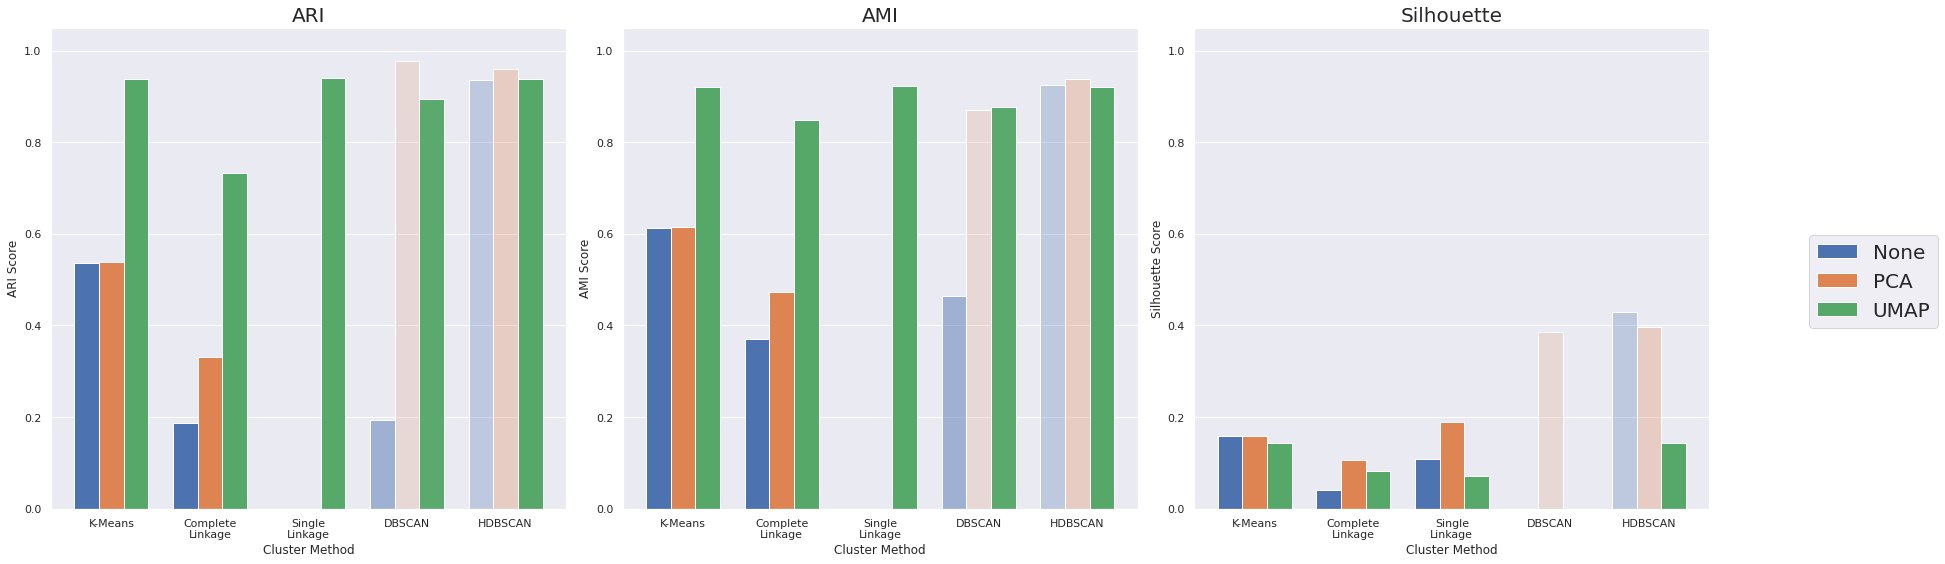

In [68]:
plot_scores(
    pd.concat([usps_raw_results_long, usps_pca_results_long, usps_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)

# Buildings Clustering

In [69]:
raw_buildings = buildings_data.astype(np.float32)

In [70]:
%%time
km_labels = cluster.KMeans(n_clusters=40).fit_predict(raw_buildings)
cl_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(raw_buildings)
sl_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(raw_buildings)
db_labels = cluster.DBSCAN(eps=6000).fit_predict(raw_buildings)
hd_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(raw_buildings)

CPU times: user 46min 47s, sys: 1min 9s, total: 47min 56s
Wall time: 34min 1s


In [71]:
buildings_raw_results = pd.DataFrame(
    [
        eval_clusters(km_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_raw_results_long = buildings_raw_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_raw_results_long["Dim Reduction"] = "None"

ARI: 0.2022
AMI: 0.4992
Silhouette: 0.0706
ARI: 0.1322
AMI: 0.4259
Silhouette: 0.0427
ARI: 0.0036
AMI: 0.0861
Silhouette: -0.0796
Pct clustered: 96.86%
ARI: 0.4303
AMI: 0.7810
Silhouette: 0.2044
Pct clustered: 44.16%
ARI: 0.6070
AMI: 0.8563
Silhouette: 0.0768
Pct clustered: 63.93%


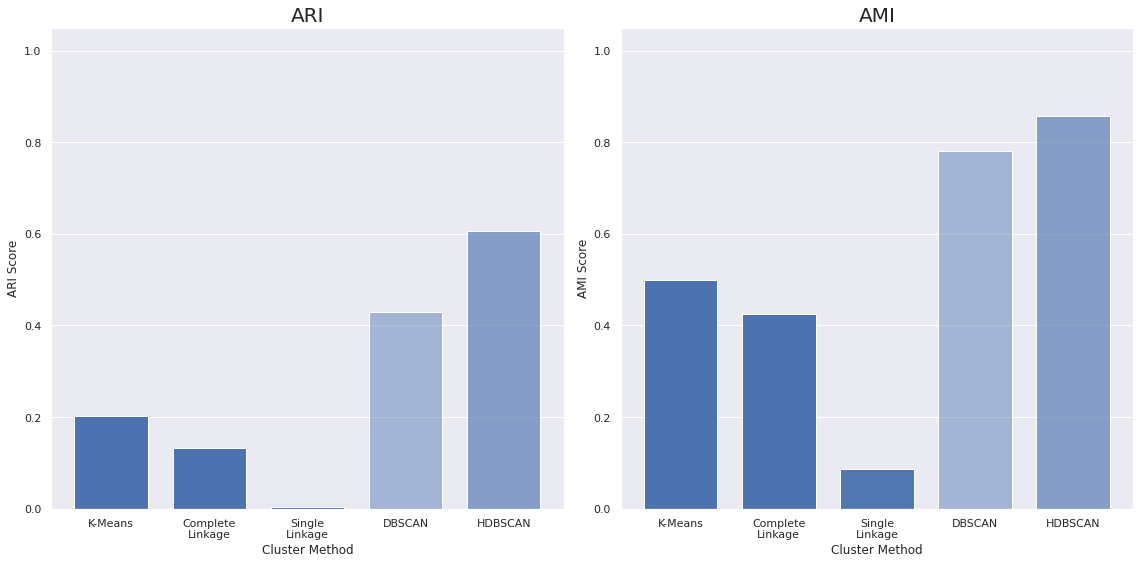

In [72]:
plot_scores(buildings_raw_results_long)

In [73]:
pca_buildings = PCA(n_components=32).fit_transform(raw_buildings)

In [74]:
%%time
km_pca_labels = cluster.KMeans(n_clusters=40).fit_predict(pca_buildings)
cl_pca_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(pca_buildings)
sl_pca_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(pca_buildings)
db_pca_labels = cluster.DBSCAN(eps=2000.0).fit_predict(pca_buildings)
hd_pca_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(pca_buildings)

CPU times: user 12.8 s, sys: 374 ms, total: 13.2 s
Wall time: 3.24 s


In [75]:
buildings_pca_results = pd.DataFrame(
    [
        eval_clusters(km_pca_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_pca_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_pca_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_pca_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_pca_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_pca_results_long = buildings_pca_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_pca_results_long["Dim Reduction"] = "PCA"

ARI: 0.1843
AMI: 0.4805
Silhouette: 0.0679
ARI: 0.1242
AMI: 0.4252
Silhouette: 0.0367
ARI: 0.0133
AMI: 0.2430
Silhouette: -0.0987
Pct clustered: 96.89%
ARI: 0.3989
AMI: 0.7875
Silhouette: 0.1591
Pct clustered: 56.22%
ARI: 0.5708
AMI: 0.8360
Silhouette: 0.0596
Pct clustered: 70.78%


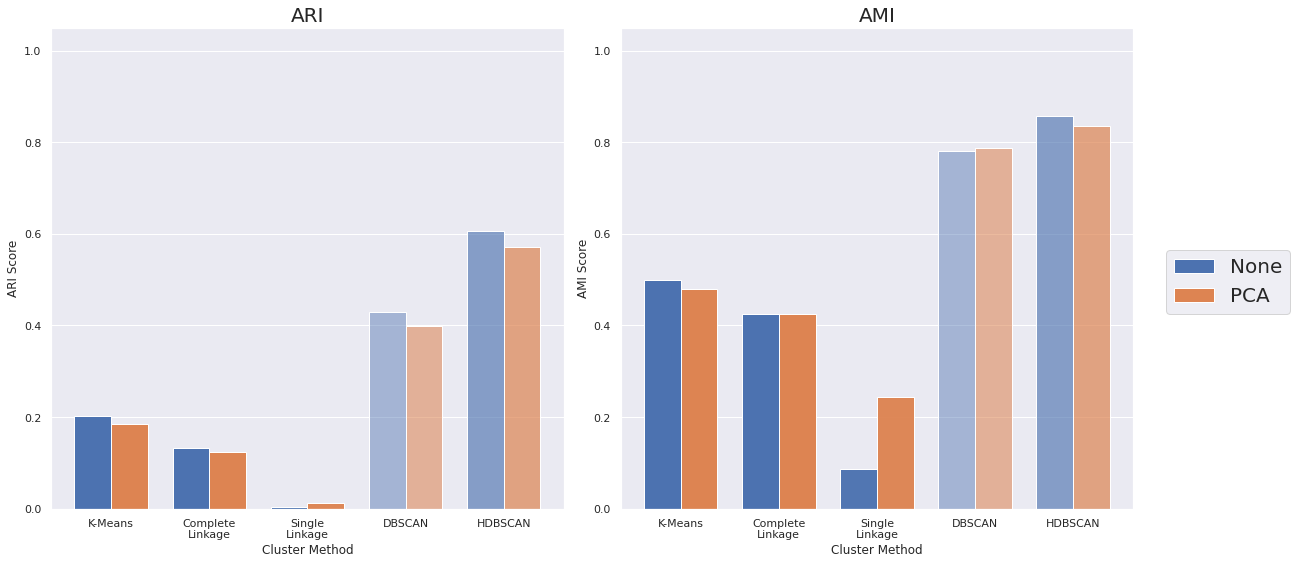

In [76]:
plot_scores(pd.concat([buildings_raw_results_long, buildings_pca_results_long]))

In [77]:
umap_buildings = umap.UMAP(n_neighbors=8, n_components=4, min_dist=1e-8, random_state=42, n_epochs=1000).fit_transform(raw_buildings)

In [78]:
%%time
km_umap_labels = cluster.KMeans(n_clusters=40).fit_predict(umap_buildings)
cl_umap_labels = cluster.AgglomerativeClustering(n_clusters=40, linkage="complete").fit_predict(umap_buildings)
sl_umap_labels = cluster.AgglomerativeClustering(n_clusters=120, linkage="single").fit_predict(umap_buildings)
db_umap_labels = cluster.DBSCAN(eps=0.25).fit_predict(umap_buildings)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=20).fit_predict(umap_buildings)

CPU times: user 5.68 s, sys: 201 ms, total: 5.88 s
Wall time: 1.19 s


In [79]:
buildings_umap_results = pd.DataFrame(
    [
        eval_clusters(km_umap_labels, buildings_target, raw_buildings, cluster_method="K-Means"),
        eval_clusters(cl_umap_labels, buildings_target, raw_buildings, cluster_method="Complete\nLinkage"),
        eval_clusters(sl_umap_labels, buildings_target, raw_buildings, cluster_method="Single\nLinkage"),
        eval_clusters(db_umap_labels, buildings_target, raw_buildings, cluster_method="DBSCAN"),
        eval_clusters(hd_umap_labels, buildings_target, raw_buildings, cluster_method="HDBSCAN"),
    ]
)
buildings_umap_results_long = buildings_umap_results.melt(["Method", "Pct Clustered"], var_name="Score Type", value_name="Score")
buildings_umap_results_long["Dim Reduction"] = "UMAP"

ARI: 0.2392
AMI: 0.5828
Silhouette: -0.0042
ARI: 0.2456
AMI: 0.5826
Silhouette: -0.0173
ARI: 0.3156
AMI: 0.6584
Silhouette: 0.0339
Pct clustered: 99.38%
ARI: 0.3199
AMI: 0.6612
Silhouette: 0.0353
Pct clustered: 99.21%
ARI: 0.3348
AMI: 0.6816
Silhouette: 0.0505
Pct clustered: 91.14%


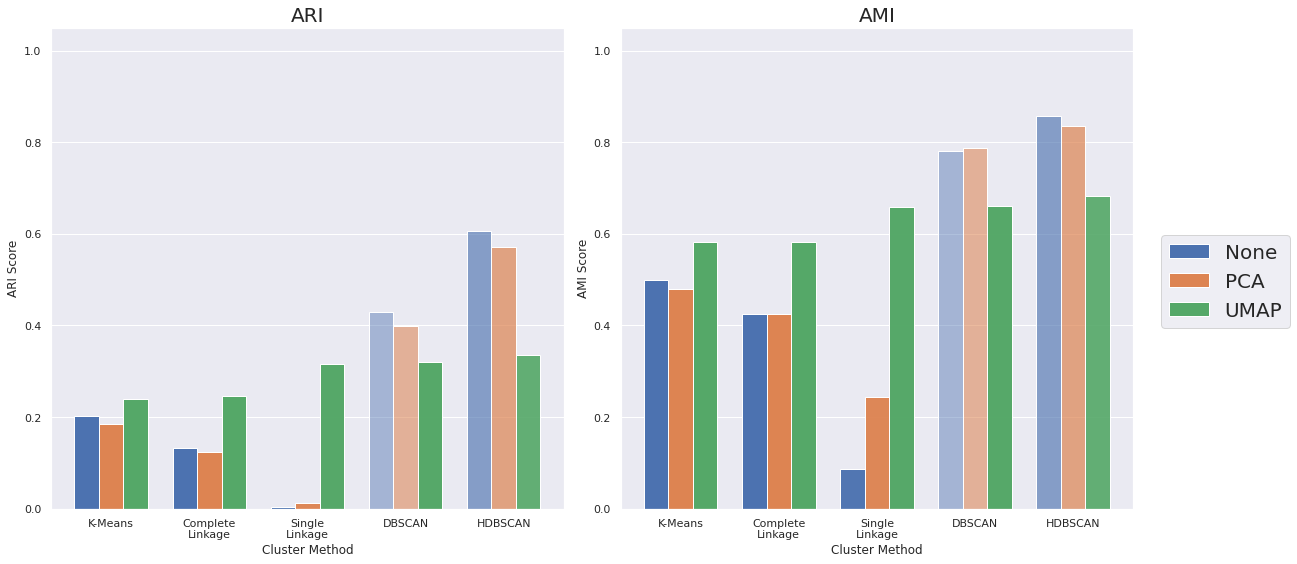

In [80]:
plot_scores(pd.concat([buildings_raw_results_long, buildings_pca_results_long, buildings_umap_results_long]))

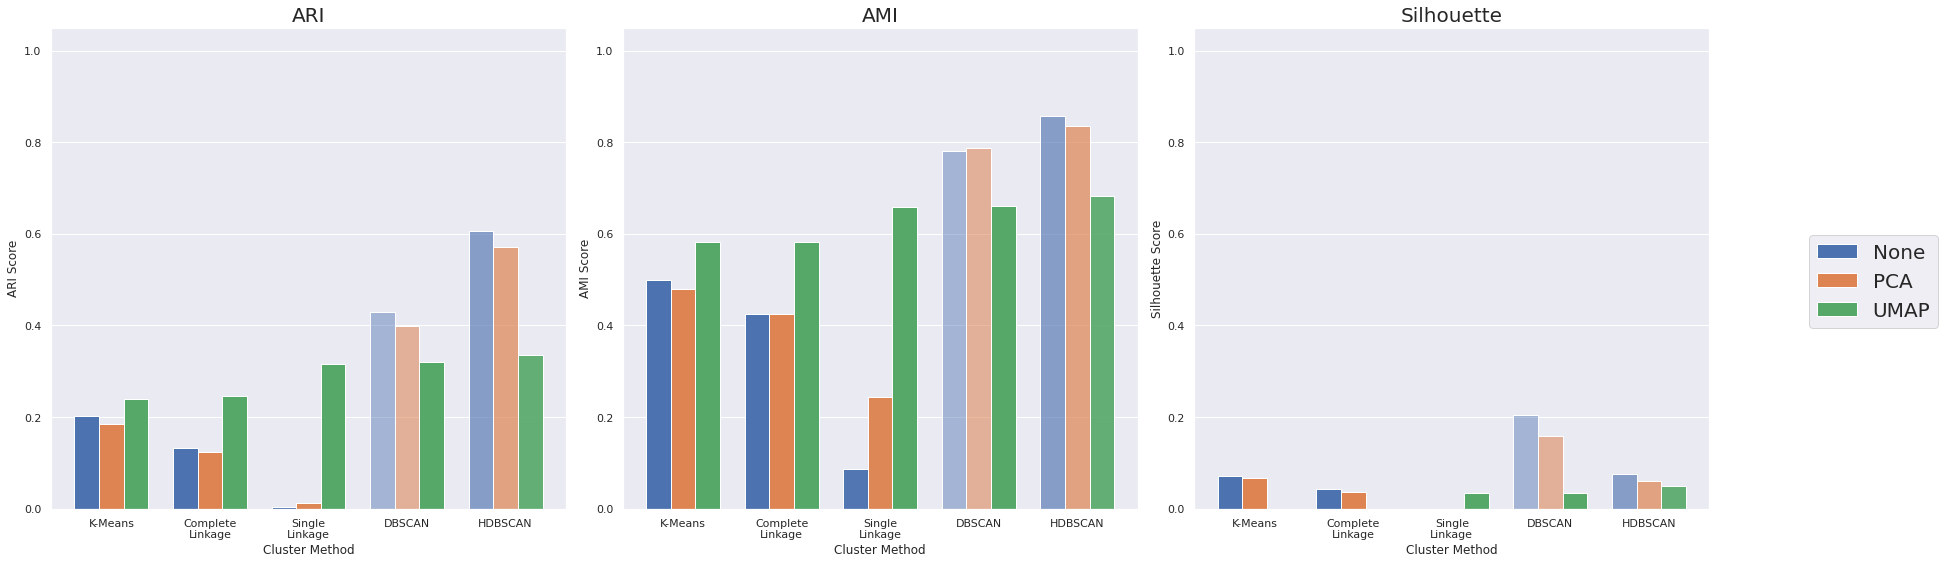

In [81]:
plot_scores(
    pd.concat([buildings_raw_results_long, buildings_pca_results_long, buildings_umap_results_long]),
    score_types=("ARI", "AMI", "Silhouette")
)